In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["SERPER_API_KEY"] = os.getenv("SERPER_API_KEY")
os.environ["GOOGLE_CSE_ID"] = os.getenv("GOOGLE_CSE_ID")
os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")

In [2]:
from typing_extensions import TypedDict, Annotated

from langchain.chat_models import init_chat_model
from langchain.tools import Tool
from langchain_core.messages import HumanMessage, AIMessage, AnyMessage

from langchain_community.utilities import GoogleSerperAPIWrapper
from langchain_google_community import GoogleSearchAPIWrapper
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper
from langchain_tavily import TavilySearch

from langgraph.graph import StateGraph, END, START
from langgraph.prebuilt import ToolNode
from langgraph.graph.message import add_messages

from IPython.display import Image, display

In [3]:
llm = init_chat_model("gpt-4.1", temperature=0.7)

In [4]:
# Wrap the raw API wrappers with Tool
serper_tool = Tool(
    name = "serper",
    func = GoogleSerperAPIWrapper().run,
    description = "Useful for general medical and drug related search queries"
)


google_search_tool = Tool(
    name = "google_search",
    func = GoogleSearchAPIWrapper().run,
    description = "Use for searching the web for drug safety, symptoms, and health advice"
)


wiki_tool = Tool(
    name = "wiki",
    func = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper(top_k=10)).run,
    description = "Use for background and encyclopedic information on drugs or conditions"
)


tavily_tool = Tool(
    name = "tavily",
    func = TavilySearch().run,
    description="Use for summarizing recent web results about drug guidance and health risks."
)

# Create the list of properly wrapped Tool instances
tools = [serper_tool, google_search_tool, wiki_tool, tavily_tool]

In [5]:
react_prompt = """
You are a Medical Information and Drug Interaction Advisor agent.
...
You may use tools...
Repeat [Thought → Action → Observation] until you reach a conclusion.
**When done, end your reply with the line:**  
Final Answer: <summary>
Do NOT call any tool after you write your Final Answer.
"""

In [6]:
class State(TypedDict):
    messages : Annotated[list[AnyMessage], add_messages]

In [7]:
def reasoning_node(state: State):
    # LLM with bound tools to enable tool-calling
    llm_with_tools = llm.bind_tools(tools)
    messages = [{"role": "system", "content": react_prompt}] + state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": state["messages"] + [response]}

In [8]:
tool_node = ToolNode(tools = tools)

In [9]:
def should_continue(state: State):
    last_message = state["messages"][-1]
    # 1. If message content signals final answer, stop
    if hasattr(last_message, "content") and "final answer:" in last_message.content.lower():
        return "end"
    # 2. If there is a tool_call to run, do action step
    if hasattr(last_message, "tool_calls") and last_message.tool_calls:
        return "action"
    # 3. (Fail-safe) Stop after excessive steps to prevent infinite loop
    if len(state["messages"]) > 20:
        return "end"
    # 4. Otherwise, reason again (e.g. if agent is just thinking)
    return "reason"

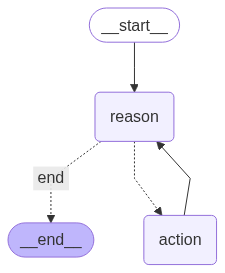

In [10]:
builder = StateGraph(State)
builder.add_node("reason", reasoning_node)
builder.add_node("action", tool_node)
builder.set_entry_point("reason")
builder.add_conditional_edges(
    "reason",
    should_continue,
    {
        "action": "action",
        "end": END,
    }
)
builder.add_edge("action", "reason")
medical_agent = builder.compile()

display(Image(medical_agent.get_graph().draw_mermaid_png()))

In [11]:
query = (
    "I take ibuprofen for headaches but also use amlodipine for blood pressure. "
    "Is it safe to take both? What’s the current guidance on non-prescription painkillers for hypertension?"
)

state = {"messages": [HumanMessage(content=query)]}
result = medical_agent.invoke(state)

print(result["messages"][-1].content)


Thought: There is a moderate interaction between ibuprofen (a non-steroidal anti-inflammatory drug, NSAID) and amlodipine (a blood pressure medication). NSAIDs like ibuprofen can reduce the effectiveness of antihypertensive medications and may increase the risk of kidney problems, especially if used frequently or in people with underlying kidney issues or heart problems.

Current guidance suggests that for people with hypertension, paracetamol (acetaminophen) is generally considered a safer alternative to NSAIDs for pain relief, as NSAIDs can raise blood pressure and blunt the effect of blood pressure medications. However, even acetaminophen may raise blood pressure slightly if taken regularly in high doses.

Final Answer: Ibuprofen can interact with amlodipine by potentially reducing its effectiveness and increasing the risk of kidney issues, so it should be used with caution if you have hypertension. Current guidelines recommend using acetaminophen (paracetamol) as the first-line ove

In [12]:
query = ("what is NSAIDs?")

state = {"messages": [HumanMessage(content=query)]}
result = medical_agent.invoke(state)

print(result["messages"][-1].content)


NSAIDs stands for Non-Steroidal Anti-Inflammatory Drugs. They are a class of medications used to reduce pain, decrease inflammation, lower fever, and prevent blood clots. Common examples include aspirin, ibuprofen, diclofenac, and naproxen—all widely available over the counter.

NSAIDs work by inhibiting cyclooxygenase (COX) enzymes, which are involved in the production of substances (prostaglandins and thromboxanes) that mediate inflammation and blood clotting. There are two main types: non-selective NSAIDs (which inhibit both COX-1 and COX-2 enzymes) and COX-2 selective inhibitors.

While effective, NSAIDs can have side effects, such as increased risk of gastrointestinal ulcers and bleeding, heart attack, kidney problems, and, depending on the drug, increased risk of blood clots.

Final Answer: NSAIDs are non-steroidal anti-inflammatory drugs used to reduce pain, inflammation, and fever, but they can have side effects like gastrointestinal issues, kidney problems, and increased heart